# Search for AIMA 4th edition

Implementation of search algorithms and search problems for AIMA.

We start by defining the abstract class for a `Problem`; specific problem domains will subclass this, and then you can create individual problems with specific initial states and goals. We also define a `Node` in a search tree, and some functions on nodes: `expand` to generate successors; `path_actions` and `path_states`  to recover aspects of the path from the node.  

In [202]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations


class Problem(object):
    """The abstract class for a formal problem. You should subclass this,
    overriding `actions` and `results`, and other methods if desired.
    The default heuristic is 0 and the default step cost is 1 for all states.
    Subclasses can use other keywords besides initial and goal."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):           raise NotImplementedError
    def result(self, state, action):    raise NotImplementedError
    def is_goal(self, state):           return state == self.goal
    def step_cost(self, s, action, s1): return 1
    def h(self, node):                  return 0
    

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.state < other.state
    
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deeepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.step_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    return [] if node.parent is None else path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): return []
    return path_states(node.parent) + [node.state]

# Queues

First-in-first-out and Last-in-first-out queues, and a `PriorityQueue`, which allows you to keep a collection of items, and continually remove from it the item with minimum `f(item)` score.

In [171]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

# Search Algorithms

Here are the major state-space search algorithms covered in the book:

In [172]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    frontier = FIFOQueue([Node(problem.initial)])
    reached = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure


def depth_limited_search(problem, limit=5):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    solution = failure
    while frontier:
        node = frontier.pop()
        if len(node) > limit:
            solution = cutoff
        else:
            for child in expand(problem, node):
                if problem.is_goal(child.state):
                    return child
                frontier.append(child)
    return solution

def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result
        
## TODO: bidirectional_search, rbfs

In [173]:
## Best-first search, with various f(n) functions:
        
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + h(node))


def weighted_astar_search(problem, weight=1.4, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + weight * h(node))

        
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)


def uniform_cost_search(problem):
    "Search nodes with minimum  path cost first."
    return best_first_search(problem, f=lambda node: node.path_cost)


def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda node: -len(node))

# Problem Domains

Now we turn our attention to defining some problem domains.

# Route Finding Problems

In [174]:
class RouteProblem(Problem):
    """A problem to find a route between places on a map.
    Use RouteProblem('S', 'G', map=Map(...)})"""
    
    def actions(self, state): 
        """The places neighboring `state`. (Action names are same as place names.)"""
        return self.map.neighbors[state]
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state
    
    def step_cost(self, s, action, s1):
        """The actual distance between s and s1."""
        return self.map.distances[s, s1]
    
    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return sldistance(locs[node.state], locs[self.goal])
    
def sldistance(A, B):
    "Straight-line distance between two 2D points."
    return abs(complex(*A) - complex(*B))

def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result


class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them. 
    `links` can be either [(v1, v2)...] pairs, or {(v1, v2): distance...}.
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1).
    `locations` is optional and can be {v1: (x, y)} 2D locations of vertexes."""
    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Make `links` into a dict
            links = defaultdict(lambda: 1, links)
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.locations = locations or defaultdict(lambda: (0, 0))
        self.neighbors = multimap(links)


romania = Map(
    {('O', 'Z'): 71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'): 70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'): 80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'): 90, ('B', 'U'): 85, ('H', 'U'): 98,  ('E', 'H'): 86, ('U', 'V'): 142, 
     ('I', 'V'): 92, ('I', 'N'): 87, ('P', 'R'): 97},
    dict(
    A=(91, 492), B=(400, 327), C=(253, 288), D=(165, 299), E=(562, 293), F=(305, 449),
    G=(375, 270), H=(534, 350), I=(473, 506), L=(165, 379), M=(168, 339), N=(406, 537),
    O=(131, 571), P=(320, 368), R=(233, 410), S=(207, 457), T=(94, 410), U=(456, 350),
    V=(509, 444), Z=(108, 531)))

In [175]:
romania.distances['A', 'Z']

75

In [176]:
romania.locations['A']

(91, 492)

In [177]:
romania.neighbors['A']

['Z', 'S', 'T']

# Grid Problems

A kind of route-finding problem, but on a 2D grid, with some cells being impassible obstacles.

In [178]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)

    directions = [(-1, -1), (0, -1), (1, -1),
                  (-1, 0),           (1,  0),
                  (-1, +1), (0, +1), (1, +1)]
    
    def step_cost(self, s, action, s1): return sldistance(s, s1)
    
    def h(self, node): return sldistance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return [(x + dx, y + dy) for (dx, dy) in self.directions 
                if (x + dx, y + dy) not in self.obstacles] 
    
## The following can be used to create obstacles:
    
def line(start, direction, length):
    """A line of (x, y) cells of given length, starting at start and going in direction."""
    (x, y), (dx, dy) = start, direction
    return {(x + i * dx, y + i * dy) for i in range(length)}

def random_lines(X=range(150), Y=range(60), dirs=((0, 1), (1, 0)), N=150, lengths=(3, 6, 12)):
    """Yield the cells in a collection of random lines of the given lengths."""
    dirs = ((0, 1), (1, 0))
    for _ in range(N):
        yield from line((random.choice(X), random.choice(Y)), 
                        random.choice(dirs), random.choice(lengths))

# 8 Puzzle Problems



In [205]:
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i 
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(1, 2, 3, 4, 5, 6, 7, 8, 0)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal
    
    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]
    
    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)
    
    def h(self, node):
        """The misplaced tiles heuristic."""
        return sum(s != g for (s, g) in zip(node.state, self.goal))
    

def inversions(board):
    "The number of times a smaller non-blank number follows a larger number."
    return sum((b < a and a != 0 and b != 0) for (a, b) in combinations(board, 2))
    
    
def board8(board, fmt=(3 * '{} {} {}\n')):
    "A string representing an 8-puzzle board"
    return fmt.format(*board).replace('0', '_')

In [209]:
inversions((4, 0, 2, 5, 1, 3, 7, 8, 6)), inversions((1, 2, 3, 4, 5, 6, 7, 8)) 

(8, 0)

In [181]:
print(board8((4, 0, 2, 5, 1, 3, 7, 8, 6)))

4 _ 2
5 1 3
7 8 6



# Water Pouring Problems

In a [water pouring problem](https://en.wikipedia.org/wiki/Water_pouring_puzzle) you are given a collection of jugs, each of which has a size (capacity) in, say, ounces, and a current level of water (in ounces). The actions are:
- *Fill* a jug all the way to the top (from a tap with unlimited water).
- *Dump* all the water out of a jug.
- *Pour* water from one jug to another, until either the first jug is empty, or the second is full, whichever comes first.

The goal is to measure out a certain level of water; it can appear in any of the jugs.

In a `GreenPourProblem`, the path cost is not the number of steps, but rather the total amount of water that flows from the tap during *Fill* actions. (There is an issue that non-*Fill* actions have 0 cost, which in general can lead to indefinitely long solutions, but in this problem there is a finite number of states, so we don't run into that problem.)


In [182]:
class PourProblem(Problem):
    """Problem about pouring water between jugs to achieve some water level.
    Each state is a tuples of water levels. In the initialization, also provide a tuple of 
    jug sizes, e.g. PourProblem(initial=(2, 4, 3), goal=7, sizes=(8, 16, 32)), 
    which means three jugs of sizes (8, 16, 32), initially filled with (2, 4, 3) units of 
    water, respectively, and the goal is to get a level of 7 in any one of the jugs."""
    
    def actions(self, state):
        """The actions executable in this state."""
        jugs = range(len(state))
        return ([('Fill', i)    for i in jugs if state[i] < self.sizes[i]] +
                [('Dump', i)    for i in jugs if state[i]] +
                [('Pour', i, j) for i in jugs if state[i] for j in jugs if i != j])

    def result(self, state, action):
        """The state that results from executing this action in this state."""
        result = list(state)
        act, i, *_ = action
        if act == 'Fill':   # Fill i to capacity
            result[i] = self.sizes[i]
        elif act == 'Dump': # Empty i
            result[i] = 0
        elif act == 'Pour': # Pour from i into j
            j = action[2]
            amount = min(state[i], self.sizes[j] - state[j])
            result[i] -= amount
            result[j] += amount
        return tuple(result)

    def is_goal(self, state):
        """True if the goal level is in any one of the jugs."""
        return self.goal in state
    
    
class GreenPourProblem(PourProblem): 
    """A PourProblem in which we count not the steps, but the amount of water used."""
    def step_cost(self, s, action, s1):
        "The cost is the amount of water used in a fill."
        act, i, *_ = action
        return self.sizes[i] - s[i] if act == 'Fill' else 0

# Specific Problems and Solutions

Now that we have some domains, we can make specific problems in those domains, and solve them:




In [210]:
p1 = PourProblem((1, 1, 1), 13, sizes=(2, 16, 32))
p2 = PourProblem((0, 0, 0), 21, sizes=(8, 11, 31))
p3 = PourProblem((0, 0), 8, sizes=(7,9))
p4 = PourProblem((0, 0, 0), 21, sizes=(8, 11, 31))

g1 = GreenPourProblem((1, 1, 1), 13, sizes=(2, 16, 32))
g2 = GreenPourProblem((0, 0, 0), 21, sizes=(8, 11, 31))
g3 = GreenPourProblem((0, 0), 8, sizes=(7,9))
g4 = GreenPourProblem((0, 0, 0), 21, sizes=(8, 11, 31))

r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)

d1 = GridProblem(obstacles=random_lines(N=50))
d2 = GridProblem(obstacles=random_lines(N=100))
d3 = GridProblem(obstacles=random_lines(N=150))
d4 = GridProblem(obstacles=random_lines(N=200))

e1 = EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6))
e2 = EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8))
e3 = EightPuzzle((2, 5, 8, 1, 4, 7, 0, 3, 6))
e4 = EightPuzzle((0, 1, 2, 3, 4, 5, 6, 7, 8))

In [184]:
# Solve a problem (which gives a node/path) and see the cost and states in the path
node = astar_search(r1)
node.path_cost, path_states(node)

(418, ['A', 'S', 'R', 'P', 'B'])

In [185]:
# Breadth first search finds a solution with fewer steps, but higher path cost
node = breadth_first_search(r1)
node.path_cost, path_states(node)

(450, ['A', 'S', 'F', 'B'])

In [186]:
# Solve a PourProblem and recover the actions and states
soln = breadth_first_search(p1)
path_actions(soln), path_states(soln)

([('Fill', 1), ('Pour', 1, 0), ('Dump', 0), ('Pour', 1, 0)],
 [(1, 1, 1), (1, 16, 1), (2, 15, 1), (0, 15, 1), (2, 13, 1)])

In [187]:
# Solve an 8 puzzle problem and print out each state

for s in path_states(astar_search(e1)):
    print(board8(s))

4 _ 2
5 1 3
7 8 6

4 1 2
5 _ 3
7 8 6

4 1 2
_ 5 3
7 8 6

_ 1 2
4 5 3
7 8 6

1 _ 2
4 5 3
7 8 6

1 2 _
4 5 3
7 8 6

1 2 3
4 5 _
7 8 6

1 2 3
4 5 6
7 8 _



# Reporting Metrics

Now let's gather some metrics on how well each algorithm does.  We'll use `CountCalls` to wrap a `Problem` object in such a way that calls to its methods are delegated, but each call increments a counter. Once we've solved the problem, we print out summary statistics.

In [188]:
class CountCalls:
    """Delegate all attribute accesses to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()
        
    def __getattr__(self, attr):
        self._counts[attr] += 1
        return getattr(self._object, attr)
        
def report(searchers, problems):
    "Show metrics for each searcher on each problem."
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts; 
            counts.update(len=len(path_actions(soln)), cost=soln.path_cost)
            total_counts += counts
            report_line(counts, type(p).__name__)
        report_line(total_counts, 'TOTAL\n')
        
def report_line(counts, name):
    "Print one line of the report."
    print('{:9,d} explored |{:7,d} goal |{:5.0f} cost |{:3d} steps | {}'
          .format(counts['result'], counts['is_goal'], 
                  counts['cost'], counts['len'], name))

In [189]:
# Here's a tiny report
report([astar_search], [p1, p2, p3, p4])

astar_search:
    1,325 explored |    151 goal |    4 cost |  4 steps | PourProblem
    3,381 explored |    379 goal |    9 cost |  9 steps | PourProblem
      126 explored |     31 goal |   14 cost | 14 steps | PourProblem
    3,381 explored |    379 goal |    9 cost |  9 steps | PourProblem
    8,213 explored |    940 goal |   36 cost | 36 steps | TOTAL



The last line says that, over the four problems the `astar_search` algorithm explored 8,213 nodes and did 940 goal tests. Together, the four solutions had a path cost of 36 and also a total number of steps of 36 (since step cost is 1 in these problems). 

Now let's do a bigger report:

In [190]:
report((astar_search, uniform_cost_search,  breadth_first_search, 
        breadth_first_bfs, iterative_deepening_search, depth_limited_search,
        greedy_bfs, weighted_astar_search), 
       (p1, g1, r1, r2, r3, r4, e1)) # Some easy problems

astar_search:
    1,325 explored |    151 goal |    4 cost |  4 steps | PourProblem
    1,646 explored |    186 goal |   10 cost | 12 steps | GreenPourProblem
       15 explored |      6 goal |  418 cost |  4 steps | RouteProblem
       35 explored |     16 goal |  910 cost |  9 steps | RouteProblem
       34 explored |     15 goal |  805 cost |  8 steps | RouteProblem
       22 explored |     10 goal |  445 cost |  5 steps | RouteProblem
       29 explored |     12 goal |    7 cost |  7 steps | EightPuzzle
    3,106 explored |    396 goal | 2599 cost | 49 steps | TOTAL

uniform_cost_search:
    1,325 explored |    151 goal |    4 cost |  4 steps | PourProblem
    1,646 explored |    186 goal |   10 cost | 12 steps | GreenPourProblem
       33 explored |     14 goal |  418 cost |  4 steps | RouteProblem
       43 explored |     20 goal |  910 cost |  9 steps | RouteProblem
       45 explored |     21 goal |  805 cost |  8 steps | RouteProblem
       32 explored |     13 goal |  445 cos

In [191]:
report((uniform_cost_search, breadth_first_search), 
       (p1, g1, p2, g2, p3, g3, p4, g4)) # The pouring problems, with no heuristic

uniform_cost_search:
    1,325 explored |    151 goal |    4 cost |  4 steps | PourProblem
    1,646 explored |    186 goal |   10 cost | 12 steps | GreenPourProblem
    3,381 explored |    379 goal |    9 cost |  9 steps | PourProblem
    4,048 explored |    452 goal |   21 cost | 19 steps | GreenPourProblem
      126 explored |     31 goal |   14 cost | 14 steps | PourProblem
      126 explored |     31 goal |   35 cost | 16 steps | GreenPourProblem
    3,381 explored |    379 goal |    9 cost |  9 steps | PourProblem
    4,048 explored |    452 goal |   21 cost | 19 steps | GreenPourProblem
   18,081 explored |  2,061 goal |  123 cost |102 steps | TOTAL

breadth_first_search:
    1,116 explored |    128 goal |    4 cost |  4 steps | PourProblem
    1,116 explored |    128 goal |   15 cost |  4 steps | GreenPourProblem
    3,840 explored |    423 goal |    9 cost |  9 steps | PourProblem
    3,840 explored |    423 goal |   32 cost |  9 steps | GreenPourProblem
      126 explored |  

In [134]:
report((astar_search, greedy_bfs, weighted_astar_search, uniform_cost_search), 
       (r1, r2, r3, r4, d1, d2, d3, d4, e1, e2, e3, e4)) # The problems with a heuristic

astar_search:
       15 explored |      6 goal |  418 cost |  4 steps | RouteProblem
       35 explored |     16 goal |  910 cost |  9 steps | RouteProblem
       34 explored |     15 goal |  805 cost |  8 steps | RouteProblem
       22 explored |     10 goal |  445 cost |  5 steps | RouteProblem
   16,404 explored |  2,123 goal |  121 cost |115 steps | GridProblem
   22,941 explored |  3,028 goal |  124 cost |115 steps | GridProblem
    9,378 explored |  1,293 goal |  122 cost |115 steps | GridProblem
   11,461 explored |  1,579 goal |  121 cost |115 steps | GridProblem
       29 explored |     12 goal |    7 cost |  7 steps | EightPuzzle
   27,461 explored | 10,339 goal |   23 cost | 23 steps | EightPuzzle
   37,562 explored | 14,120 goal |   24 cost | 24 steps | EightPuzzle
   15,951 explored |  5,990 goal |   22 cost | 22 steps | EightPuzzle
  141,293 explored | 38,531 goal | 3142 cost |562 steps | TOTAL

greedy_bfs:
        9 explored |      4 goal |  450 cost |  3 steps | RoutePr

This time we see that A* is an order of magnitude more efficient than the uninformed algorithms. Again,  uniform cost is optimal, but breadth-first is not.

# Visualizing Reached States

Below we compare three algorithms on grid problems:
- A* search: *f = g + h*
- Weighted A* search: *f = g + D &times; h*
- Greedy best-first search: *f = h*

We need to know the states that have been reached, but the *reached* variable is inaccessible inside `best_first_search`, so we will define a new version of `best_first_search` that is identical except that it declares *reached* to be `global`, so that we can access the states. 

In [192]:
def plot_grid_problem(grid, solution, reached=(), title='Search'):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    plt.figure(figsize=(15, 6))
    plt.axis('off'); plt.axis('equal')
    plt.scatter(*transpose(grid.obstacles), marker='s', color='darkgrey')
    plt.scatter(*transpose([grid.initial, grid.goal]), 9**2, marker='D', c='red')
    plt.scatter(*transpose(reached), 2**2, marker='.', c='blue')
    plt.scatter(*transpose(path_states(solution)), marker='s', c='black')
    plt.show()
    print('{} {} search: {:.1f} cost, {:,d} explored'
          .format(' ' * 10, title, solution.path_cost, len(reached)))
    
def transpose(matrix): return list(zip(*matrix))

def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first; make `reached` global."
    global reached # <<<<<<<<<<< Only change here
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        if node.state in reached and node.path_cost > reached[node.state].path_cost:
            continue
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

def plot3(grid): 
    """Plot the results of 3 search algorithms for this grid."""
    solution = astar_search(grid)
    plot_grid_problem(grid, solution, reached, '(a) A*')
    solution = weighted_astar_search(grid, 1.9)
    plot_grid_problem(grid, solution, reached, '(b) Weighted A*')
    solution = greedy_bfs(grid)
    plot_grid_problem(grid, solution, reached, '(c) Greedy best-first')

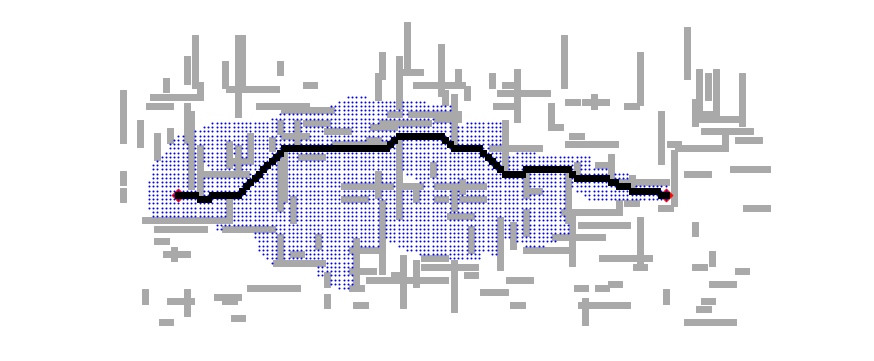

           (a) A* search: 128.3 cost, 2,710 explored


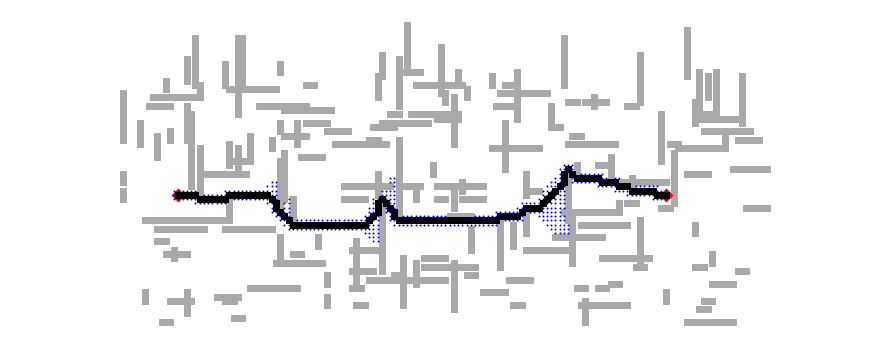

           (b) Weighted A* search: 134.3 cost, 473 explored


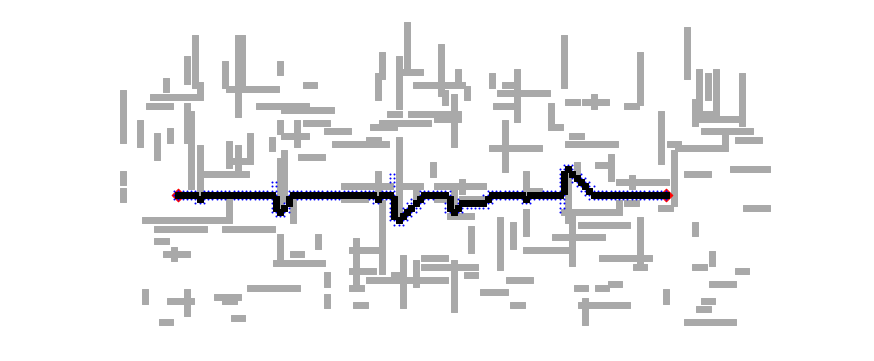

           (c) Greedy best-first search: 141.7 cost, 407 explored


In [193]:
random.seed(42)
plot3(GridProblem(obstacles=random_lines(N=200)))

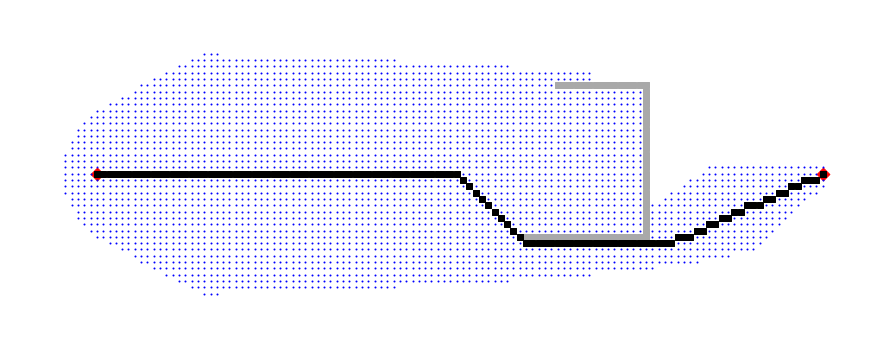

           (a) A* search: 124.1 cost, 3,305 explored


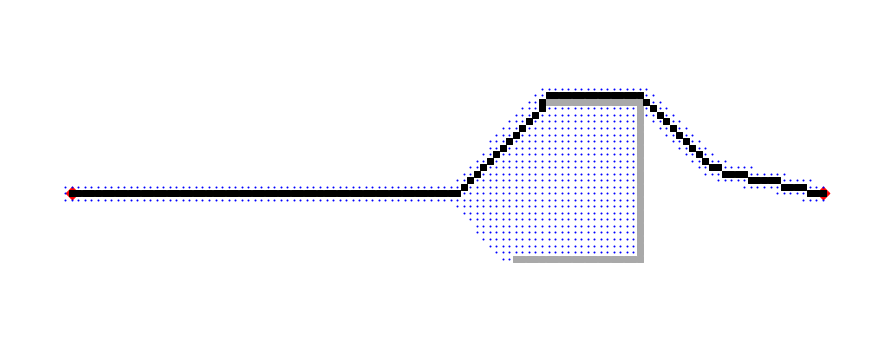

           (b) Weighted A* search: 128.0 cost, 891 explored


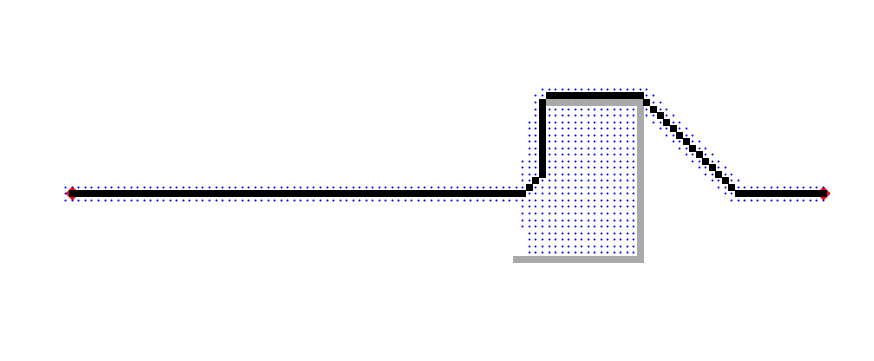

           (c) Greedy best-first search: 133.9 cost, 758 explored


In [194]:
U = (line((102, 44), (-1, 0), 15) | line((102, 20), (-1, 0), 20) | line((102, 44), (0, -1), 24))
plot3(GridProblem(obstacles=U))

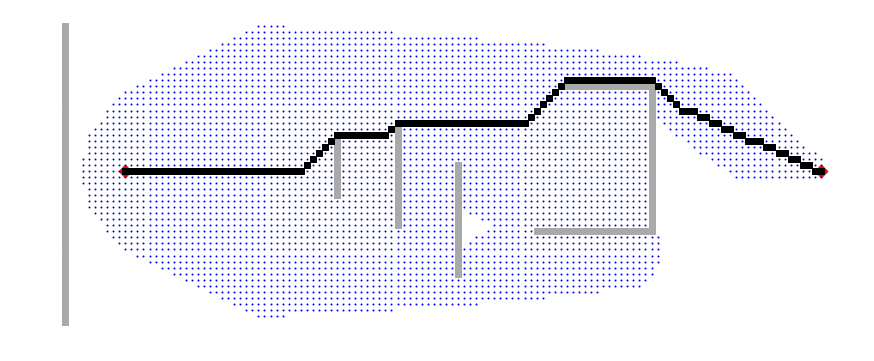

           (a) A* search: 127.4 cost, 4,058 explored


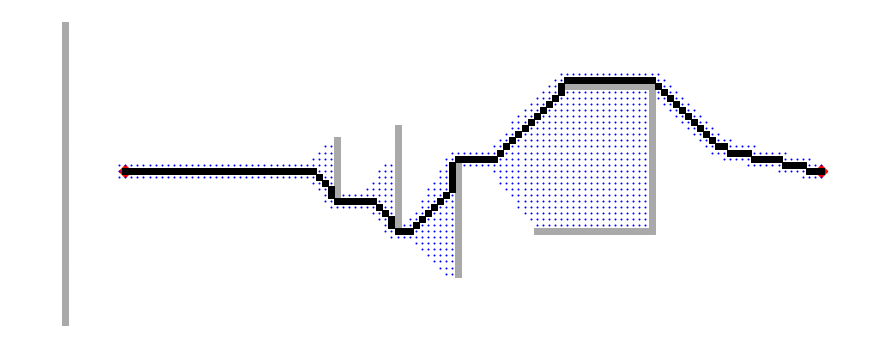

           (b) Weighted A* search: 139.8 cost, 987 explored


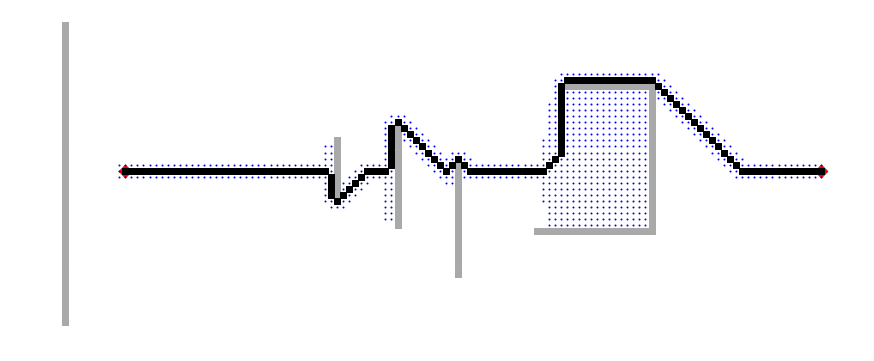

           (c) Greedy best-first search: 151.6 cost, 830 explored


In [195]:
U2 = U | (line((50, 35), (0, -1), 10) | line((60, 37), (0, -1), 17) |
          line((70, 31), (0, -1), 19) | line((5, 5), (0, 1), 50))
plot3(GridProblem(obstacles=U2))

Above, the A* algorithm finds the optiaml solution. The weighted A* gerts fooled by the first barrier, and erroneously goes below it, because that takes it less far away from the goal. It then errs again, opting to again head towards the goal and go above the third barrier, whereas at this point it would be optimal to continue the lower route. The greedy best-first search makes many mistakes, continually moving back towards the centerline rather than planning ahead.